# 1. Importing Necessary Libraries

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score,
    classification_report, confusion_matrix, precision_recall_curve
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from tensorflow import keras

# 2. Load Dataset

In [40]:
file_path = '/content/bank_transactions_data_2.csv'  # Loading file from local machine by giving path
df = pd.read_csv(file_path)  # reading the CSV file which is loaded.
print("Dataset Loaded Successfully!")
print(df.head()) # printing the data or dataset to see it's structure

Dataset Loaded Successfully!
  TransactionID AccountID  TransactionAmount      TransactionDate  \
0      TX000001   AC00128              14.09  2023-04-11 16:29:14   
1      TX000002   AC00455             376.24  2023-06-27 16:44:19   
2      TX000003   AC00019             126.29  2023-07-10 18:16:08   
3      TX000004   AC00070             184.50  2023-05-05 16:32:11   
4      TX000005   AC00411              13.45  2023-10-16 17:51:24   

  TransactionType   Location DeviceID      IP Address MerchantID Channel  \
0           Debit  San Diego  D000380  162.198.218.92       M015     ATM   
1           Debit    Houston  D000051     13.149.61.4       M052     ATM   
2           Debit       Mesa  D000235  215.97.143.157       M009  Online   
3           Debit    Raleigh  D000187  200.13.225.150       M002  Online   
4          Credit    Atlanta  D000308    65.164.3.100       M091  Online   

   CustomerAge CustomerOccupation  TransactionDuration  LoginAttempts  \
0           70            

# 3. Exploratory Data Analysis (EDA)

In [41]:
print(df.info()) # view all column name and datatype of dataset.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

In [42]:
print("Missing Values:\n", df.isnull().sum()) # print if any missing values.

Missing Values:
 TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
dtype: int64


## Target distribution

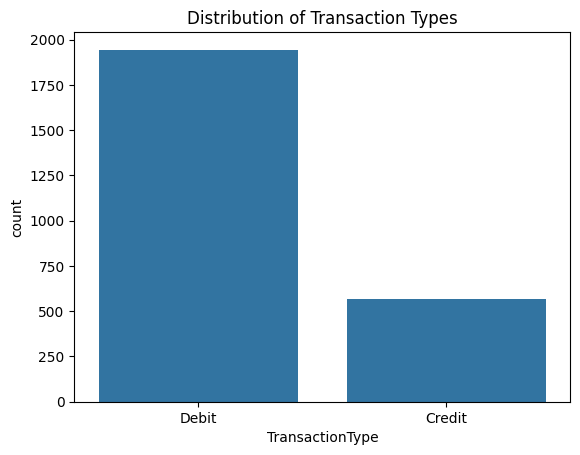

In [43]:
# Target distribution
sns.countplot(x='TransactionType', data=df)  # Display of count plot
plt.title("Distribution of Transaction Types")
plt.show()

## Correlation Matrix

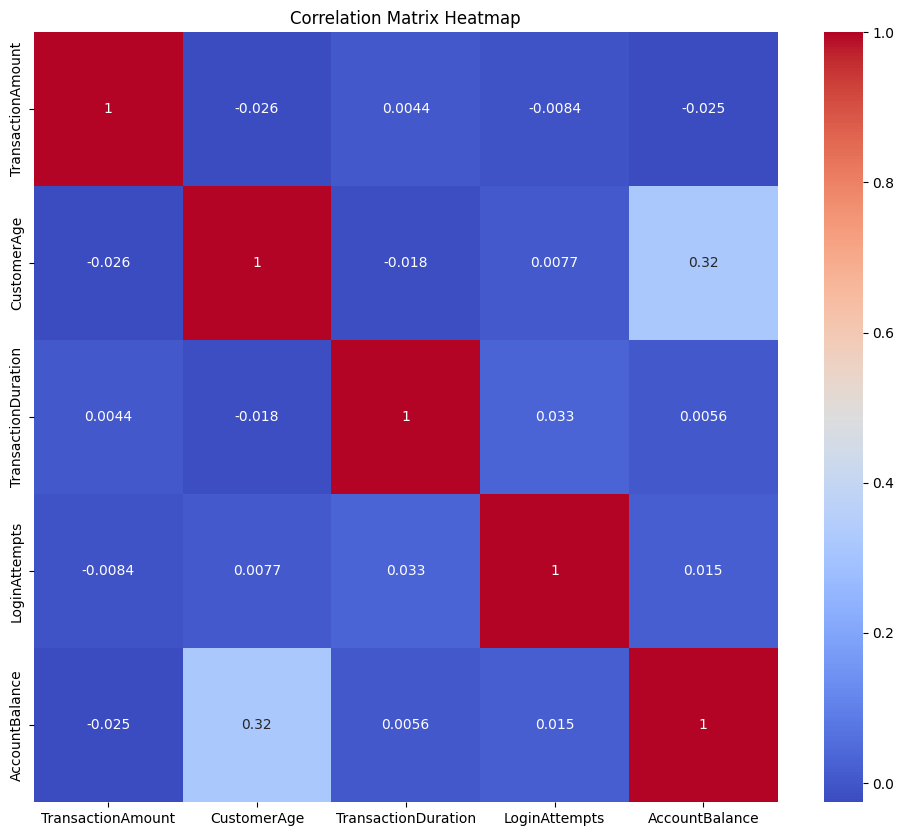

In [44]:
# Correlation Matrix
# Convert TransactionDate to datetime if it's a string

if 'TransactionDate' in df.columns and df['TransactionDate'].dtype == 'object':
    df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

plt.figure(figsize=(12, 10))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

## Histograms and Boxplots

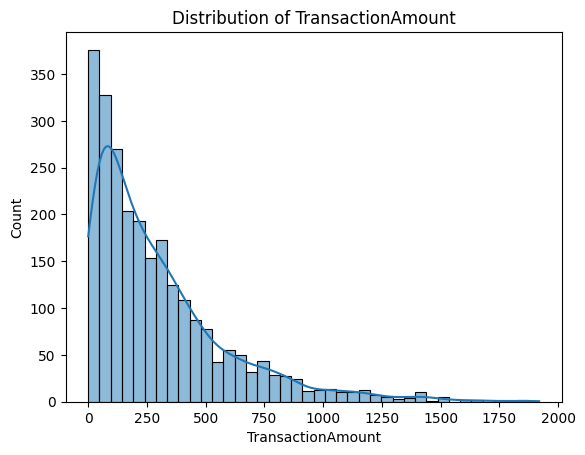

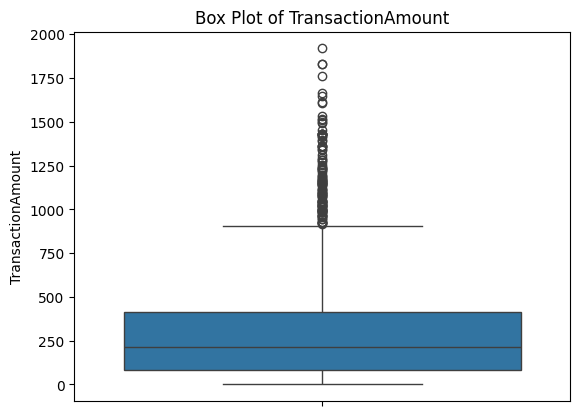

In [45]:
# Visualize distribution and spread of numerical features
numerical_features = ['TransactionAmount', 'CustomerID']
for col in numerical_features:
    if col in df.columns:
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.show()
        sns.boxplot(y=df[col])
        plt.title(f'Box Plot of {col}')
        plt.show()

# 4. Data Preprocessing & Feature Engineering

In [46]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]
print(f"Number of duplicate rows: {len(duplicate_rows)}")


Number of duplicate rows: 0


In [47]:
# Feature engineering: convert date to timestamp and drop original
df.drop_duplicates(inplace=True)
if 'TransactionDate' in df.columns:
    df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
    df['TransactionTimestamp'] = df['TransactionDate'].astype(int) / 10**9
    df.drop(columns=['TransactionDate'], inplace=True)

## Log Transformation

In [48]:
# Apply log transformation to reduce skewness
if 'TransactionAmount' in df.columns:
    df['TransactionAmount_log'] = np.log1p(df['TransactionAmount'])

## Encoding

In [49]:
# Encode categorical columns using LabelEncoder
label_enc = LabelEncoder()
categorical_cols = ['TransactionType', 'Channel', 'CustomerOccupation', 'Location']
for col in categorical_cols:
    if col in df.columns:
        df[col] = label_enc.fit_transform(df[col].astype(str))

## Drop unnecessary columns


In [50]:
# Drop irrelevant or ID-based columns
df.drop(columns=['TransactionID', 'AccountID', 'MerchantID', 'DeviceID', 'IP Address'], inplace=True, errors='ignore')

# Keep only numeric features
df = df.select_dtypes(include=['number'])

# 5. Train-Test Split and SMOTE

Validation Strategy:

80/20 stratified train-test split to preserve class balance.

 XGBoost will also use 3-fold cross-validation in tuning.

In [51]:
# Separate features and target
X = df.drop(columns=['TransactionType'])
y = df['TransactionType']

In [52]:
# Apply SMOTE to balance class distribution
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [53]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [54]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 6. Model Training: Random Forest & XGBoost

In [55]:
# Setup XGBoost with a parameter grid for tuning
xgb_model = XGBClassifier()
param_grid_xgb = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [5]
}


In [56]:
# Use 3-fold cross-validation during GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(
    xgb_model, param_grid_xgb, scoring='roc_auc', cv=3, n_jobs=-1
)
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_

In [57]:
# Train Random Forest without hyperparameter tuning
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

# 7. Deep Learning Model: MLP

In [58]:
# Define a simple MLP model with dropout for regularization
dl_model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  # For binary classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:
# Compile and train the model
dl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
dl_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

In [60]:
# Get predicted probabilities from the deep learning model
y_prob_dl = dl_model.predict(X_test).flatten()

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


# 8. Model Evaluation: Metrics & ROC

In [61]:
# Evaluate all three models: XGBoost, Random Forest, Deep Learning
models = {
    'XGBoost': (best_xgb.predict(X_test), best_xgb.predict_proba(X_test)[:, 1]),
    'Random Forest': (rf_model.predict(X_test), rf_model.predict_proba(X_test)[:, 1]),
    'Deep Learning': ((y_prob_dl > 0.5).astype(int), y_prob_dl)
}


XGBoost Evaluation:
Accuracy: 0.78
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       389
           1       0.79      0.75      0.77       389

    accuracy                           0.78       778
   macro avg       0.78      0.78      0.77       778
weighted avg       0.78      0.78      0.77       778

Confusion Matrix:
 [[313  76]
 [ 99 290]]
ROC AUC: 0.85

Random Forest Evaluation:
Accuracy: 0.79
              precision    recall  f1-score   support

           0       0.77      0.80      0.79       389
           1       0.80      0.77      0.78       389

    accuracy                           0.79       778
   macro avg       0.79      0.79      0.79       778
weighted avg       0.79      0.79      0.79       778

Confusion Matrix:
 [[313  76]
 [ 91 298]]
ROC AUC: 0.86

Deep Learning Evaluation:
Accuracy: 0.67
              precision    recall  f1-score   support

           0       0.64      0.76      0.70       389
     

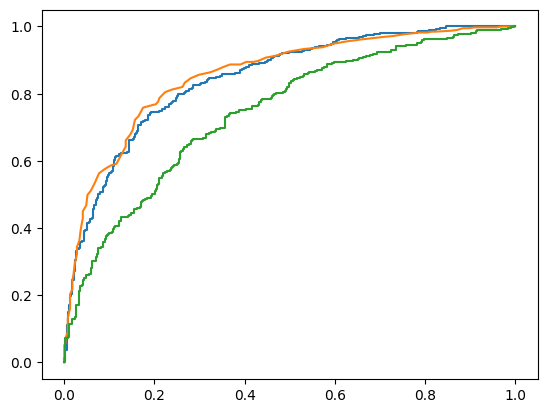

In [62]:
# Loop through each model and print evaluation metrics
for name, (y_pred, y_prob) in models.items():
    print(f"\n{name} Evaluation:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.2f}")

     # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_prob):.2f})')


In [63]:
print("Sample y_prob from XGBoost:", models['XGBoost'][1][:10])
print("Sample y_test:", y_test[:10])


Sample y_prob from XGBoost: [0.41511804 0.13028677 0.5879784  0.4987372  0.23390494 0.26848245
 0.19192997 0.49864256 0.9049947  0.283028  ]
Sample y_test: 2125    1
3605    0
139     1
1512    0
3663    0
1032    1
3210    0
2449    0
490     1
2499    0
Name: TransactionType, dtype: int64


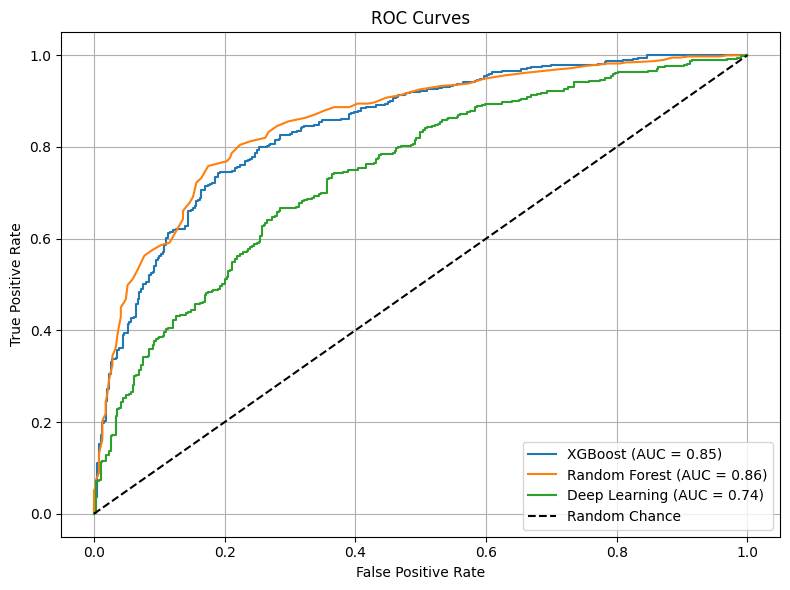

In [64]:
#  Clean & Safe ROC Plot for All Models

plt.figure(figsize=(8, 6))

# Plot ROC for each model
for name, (y_pred, y_prob) in models.items():
    try:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
    except Exception as e:
        print(f"⚠️ Skipping {name} due to error: {e}")

# Add random baseline line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# 9. Ensemble Model: Soft Voting

In [65]:
# Average the probabilities from all models and threshold for prediction
y_ensemble = (models['XGBoost'][1] + models['Random Forest'][1] + models['Deep Learning'][1]) / 3
y_pred_ensemble = (y_ensemble > 0.5).astype(int)

In [66]:
# Evaluate ensemble performance
print("\nEnsemble Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ensemble):.2f}")
print(classification_report(y_test, y_pred_ensemble))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ensemble))
print(f"Ensemble ROC AUC: {roc_auc_score(y_test, y_ensemble):.2f}")


Ensemble Model Evaluation:
Accuracy: 0.77
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       389
           1       0.79      0.74      0.76       389

    accuracy                           0.77       778
   macro avg       0.77      0.77      0.77       778
weighted avg       0.77      0.77      0.77       778

Confusion Matrix:
 [[314  75]
 [102 287]]
Ensemble ROC AUC: 0.85


# 10. Error Analysis

In [67]:
# Identify and count misclassified samples
misclassified = X_test[(y_pred_ensemble != y_test)]
print(f"\nTotal Misclassified Samples: {len(misclassified)}")


Total Misclassified Samples: 177


# 11. Learning Curve: Random Forest

In [68]:
# Plot training vs validation accuracy as training size increases
train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

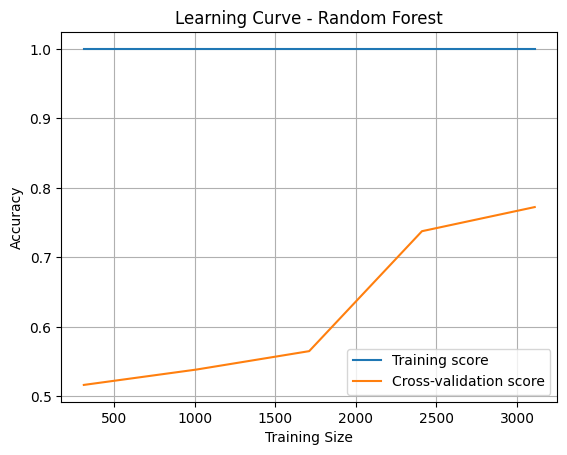

In [69]:
# Plot learning curve
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.title("Learning Curve - Random Forest")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# 12. Timing Analysis

In [70]:
# Measure time to train and predict using Random Forest
start_time = time.time()
rf_model.fit(X_train, y_train)
train_duration = time.time() - start_time

start_time = time.time()
_ = rf_model.predict(X_test)
inference_duration = time.time() - start_time

print(f"\nTraining Time (Random Forest): {train_duration:.2f} sec")
print(f"Inference Time (Random Forest): {inference_duration:.4f} sec")


Training Time (Random Forest): 1.25 sec
Inference Time (Random Forest): 0.0208 sec
